In [1]:
# Instead of doing E-field and H-field updates separately
# we instead do it in the same compute pass, and then swap out the E and H field buffers
import numpy as np
import numpy.linalg as la
import pyopencl as cl
import pyopencl.array as cl_array
from tqdm import tqdm
import time
from contextlib import contextmanager
from functools import reduce
import math
from pprint import pprint
import matplotlib.pyplot as plt
import sys
import threading

In [2]:
platforms = cl.get_platforms()

def get_platform_info(platform):
    keys = [
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "HOST_TIMER_RESOLUTION",
        "NAME",
        "NUMERIC_VERSION",
        "PROFILE",
        "VENDOR",
        "VERSION",
    ]
    info = {}
    for key in keys:
        try:
            value = platform.get_info(getattr(cl.platform_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

platform_infos = list(map(get_platform_info, platforms))
if len(platforms) > 1:
    print(f"> Listing platforms ({len(platforms)})")
    pprint(platform_infos)

platform_index = 0
platform = platforms[platform_index]
platform_info = platform_infos[platform_index]

print(f"> Selected platform ({platform_index})")
pprint(platform_info)

def get_device_info(device):
    keys = [
        "ADDRESS_BITS",
        "ATOMIC_FENCE_CAPABILITIES",
        "ATOMIC_MEMORY_CAPABILITIES",
        "ATTRIBUTE_ASYNC_ENGINE_COUNT_NV",
        "AVAILABLE",
        "AVAILABLE_ASYNC_QUEUES_AMD",
        "BOARD_NAME_AMD",
        "BUILT_IN_KERNELS",
        "BUILT_IN_KERNELS_WITH_VERSION",
        "COMPILER_AVAILABLE",
        "COMPUTE_CAPABILITY_MAJOR_NV",
        "COMPUTE_CAPABILITY_MINOR_NV",
        "DEVICE_ENQUEUE_CAPABILITIES",
        "DOUBLE_FP_CONFIG",
        "DRIVER_VERSION",
        "ENDIAN_LITTLE",
        "ERROR_CORRECTION_SUPPORT",
        "EXECUTION_CAPABILITIES",
        "EXTENSIONS",
        "EXTENSIONS_WITH_VERSION",
        "EXT_MEM_PADDING_IN_BYTES_QCOM",
        "GENERIC_ADDRESS_SPACE_SUPPORT",
        "GFXIP_MAJOR_AMD",
        "GFXIP_MINOR_AMD",
        "GLOBAL_FREE_MEMORY_AMD",
        "GLOBAL_MEM_CACHELINE_SIZE",
        "GLOBAL_MEM_CACHE_SIZE",
        "GLOBAL_MEM_CACHE_TYPE",
        "GLOBAL_MEM_CHANNELS_AMD",
        "GLOBAL_MEM_CHANNEL_BANKS_AMD",
        "GLOBAL_MEM_CHANNEL_BANK_WIDTH_AMD",
        "GLOBAL_MEM_SIZE",
        "GLOBAL_VARIABLE_PREFERRED_TOTAL_SIZE",
        "GPU_OVERLAP_NV",
        "HALF_FP_CONFIG",
        "HOST_UNIFIED_MEMORY",
        "ILS_WITH_VERSION",
        "IL_VERSION",
        "IMAGE2D_MAX_HEIGHT",
        "IMAGE2D_MAX_WIDTH",
        "IMAGE3D_MAX_DEPTH",
        "IMAGE3D_MAX_HEIGHT",
        "IMAGE3D_MAX_WIDTH",
        "IMAGE_BASE_ADDRESS_ALIGNMENT",
        "IMAGE_MAX_ARRAY_SIZE",
        "IMAGE_MAX_BUFFER_SIZE",
        "IMAGE_PITCH_ALIGNMENT",
        "IMAGE_SUPPORT",
        "INTEGRATED_MEMORY_NV",
        "KERNEL_EXEC_TIMEOUT_NV",
        "LINKER_AVAILABLE",
        "LOCAL_MEM_BANKS_AMD",
        "LOCAL_MEM_SIZE",
        "LOCAL_MEM_SIZE_PER_COMPUTE_UNIT_AMD",
        "LOCAL_MEM_TYPE",
        "MAX_ATOMIC_COUNTERS_EXT",
        "MAX_CLOCK_FREQUENCY",
        "MAX_COMPUTE_UNITS",
        "MAX_CONSTANT_ARGS",
        "MAX_CONSTANT_BUFFER_SIZE",
        "MAX_GLOBAL_VARIABLE_SIZE",
        "MAX_MEM_ALLOC_SIZE",
        "MAX_NUM_SUB_GROUPS",
        "MAX_ON_DEVICE_EVENTS",
        "MAX_ON_DEVICE_QUEUES",
        "MAX_PARAMETER_SIZE",
        "MAX_PIPE_ARGS",
        "MAX_READ_IMAGE_ARGS",
        "MAX_READ_WRITE_IMAGE_ARGS",
        "MAX_SAMPLERS",
        "MAX_WORK_GROUP_SIZE",
        "MAX_WORK_GROUP_SIZE_AMD",
        "MAX_WORK_ITEM_DIMENSIONS",
        "MAX_WORK_ITEM_SIZES",
        "MAX_WRITE_IMAGE_ARGS",
        "MEM_BASE_ADDR_ALIGN",
        "ME_VERSION_INTEL",
        "MIN_DATA_TYPE_ALIGN_SIZE",
        "NAME",
        "NATIVE_VECTOR_WIDTH_CHAR",
        "NATIVE_VECTOR_WIDTH_DOUBLE",
        "NATIVE_VECTOR_WIDTH_FLOAT",
        "NATIVE_VECTOR_WIDTH_HALF",
        "NATIVE_VECTOR_WIDTH_INT",
        "NATIVE_VECTOR_WIDTH_LONG",
        "NATIVE_VECTOR_WIDTH_SHORT",
        "NON_UNIFORM_WORK_GROUP_SUPPORT",
        "NUMERIC_VERSION",
        "NUM_SIMULTANEOUS_INTEROPS_INTEL",
        "OPENCL_C_ALL_VERSIONS",
        "OPENCL_C_FEATURES",
        "OPENCL_C_VERSION",
        "PAGE_SIZE_QCOM",
        "PARENT_DEVICE",
        "PARTITION_AFFINITY_DOMAIN",
        "PARTITION_MAX_SUB_DEVICES",
        "PARTITION_PROPERTIES",
        "PARTITION_TYPE",
        "PCIE_ID_AMD",
        "PCI_BUS_ID_NV",
        "PCI_DOMAIN_ID_NV",
        "PCI_SLOT_ID_NV",
        "PIPE_MAX_ACTIVE_RESERVATIONS",
        "PIPE_MAX_PACKET_SIZE",
        "PIPE_SUPPORT",
        "PLATFORM",
        "PREFERRED_CONSTANT_BUFFER_SIZE_AMD",
        "PREFERRED_GLOBAL_ATOMIC_ALIGNMENT",
        "PREFERRED_INTEROP_USER_SYNC",
        "PREFERRED_LOCAL_ATOMIC_ALIGNMENT",
        "PREFERRED_PLATFORM_ATOMIC_ALIGNMENT",
        "PREFERRED_VECTOR_WIDTH_CHAR",
        "PREFERRED_VECTOR_WIDTH_DOUBLE",
        "PREFERRED_VECTOR_WIDTH_FLOAT",
        "PREFERRED_VECTOR_WIDTH_HALF",
        "PREFERRED_VECTOR_WIDTH_INT",
        "PREFERRED_VECTOR_WIDTH_LONG",
        "PREFERRED_VECTOR_WIDTH_SHORT",
        "PREFERRED_WORK_GROUP_SIZE_AMD",
        "PREFERRED_WORK_GROUP_SIZE_MULTIPLE",
        "PRINTF_BUFFER_SIZE",
        "PROFILE",
        "PROFILING_TIMER_OFFSET_AMD",
        "PROFILING_TIMER_RESOLUTION",
        "QUEUE_ON_DEVICE_MAX_SIZE",
        "QUEUE_ON_DEVICE_PREFERRED_SIZE",
        "QUEUE_ON_DEVICE_PROPERTIES",
        "QUEUE_ON_HOST_PROPERTIES",
        "QUEUE_PROPERTIES",
        "REFERENCE_COUNT",
        "REGISTERS_PER_BLOCK_NV",
        "SIMD_INSTRUCTION_WIDTH_AMD",
        "SIMD_PER_COMPUTE_UNIT_AMD",
        "SIMD_WIDTH_AMD",
        "SIMULTANEOUS_INTEROPS_INTEL",
        "SINGLE_FP_CONFIG",
        "SPIR_VERSIONS",
        "SUB_GROUP_INDEPENDENT_FORWARD_PROGRESS",
        "SVM_CAPABILITIES",
        "THREAD_TRACE_SUPPORTED_AMD",
        "TOPOLOGY_AMD",
        "TYPE",
        "VENDOR",
        "VENDOR_ID",
        "VERSION",
        "WARP_SIZE_NV",
        "WAVEFRONT_WIDTH_AMD",
        "WORK_GROUP_COLLECTIVE_FUNCTIONS_SUPPORT",
    ]
    info = {}
    for key in keys:
        try:
            value = device.get_info(getattr(cl.device_info, key))
            info.setdefault(key.lower(), value)
        except:
            pass
    for key in ("extensions",):
        values = info.get(key, None)
        if values:
            values = values.split(" ")
            values = [v.strip() for v in values]
            values = [v for v in values if len(v) > 0]
            info[key] = set(values)
    return info

devices = platform.get_devices()
device_infos = list(map(get_device_info, devices))
if len(devices) > 1:
    print(f"> Listing devices ({len(devices)})")
    pprint(device_infos)

device_index = 0
device = devices[device_index]
device_info = device_infos[device_index]

print(f"> Selected device ({device_index})")
pprint(device_info)

context = cl.Context(devices=[device])

> Selected platform (0)
{'extensions': {'cl_amd_event_callback',
                'cl_amd_offline_devices',
                'cl_khr_d3d10_sharing',
                'cl_khr_d3d11_sharing',
                'cl_khr_dx9_media_sharing',
                'cl_khr_icd'},
 'host_timer_resolution': 100,
 'name': 'AMD Accelerated Parallel Processing',
 'profile': 'FULL_PROFILE',
 'vendor': 'Advanced Micro Devices, Inc.',
 'version': 'OpenCL 2.1 AMD-APP (3628.0)'}
> Selected device (0)
{'address_bits': 64,
 'available': 1,
 'available_async_queues_amd': 2,
 'board_name_amd': 'AMD Radeon(TM) Graphics',
 'built_in_kernels': '',
 'compiler_available': 1,
 'double_fp_config': 63,
 'driver_version': '3628.0 (PAL,LC)',
 'endian_little': 1,
 'error_correction_support': 0,
 'execution_capabilities': 1,
 'extensions': {'cl_amd_copy_buffer_p2p',
                'cl_amd_device_attribute_query',
                'cl_amd_media_ops',
                'cl_amd_media_ops2',
                'cl_amd_planar_yuv',
       

In [3]:
class NanoTimer:
    def __init__(self):
        self.start_ns = None
        self.end_ns = None
    
    def __enter__(self):
        self.start_ns = time.time_ns()
        return self

    def __exit__(self, *args):
        self.end_ns = time.time_ns()        

    def get_delta_ns(self):
        return self.end_ns - self.start_ns

In [4]:
program_source = f"""
    __kernel void update(
        __global const float *E, __global const float *H,
        __global float *E_out, __global float *H_out,
        __global const float *A0, __global const float *A1, __global const float *B0,
        int Nx, int Ny, int Nz
    ) {{
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);
        const int iz = get_global_id(2);

        if (ix >= Nx) return;
        if (iy >= Ny) return;
        if (iz >= Nz) return;

        const int n_dims = 3;
        const int Nzy = Nz*Ny;
        const int i0 = iz + iy*Nz + ix*Nzy;
        const int i = n_dims*i0;

        // curl(H)
        const int hz = n_dims*(((iz+1) % Nz) + iy*Nz + ix*Nzy);
        const int hy = n_dims*(iz + ((iy+1) % Ny)*Nz + ix*Nzy);
        const int hx = n_dims*(iz + iy*Nz + ((ix+1) % Nx)*Nzy);
        const float dHz_dy = H[hy+2]-H[i+2];
        const float dHy_dz = H[hz+1]-H[i+1];
        const float dHx_dz = H[hz+0]-H[i+0];
        const float dHz_dx = H[hx+2]-H[i+2];
        const float dHy_dx = H[hx+1]-H[i+1]; 
        const float dHx_dy = H[hy+0]-H[i+0];
        const float cHx = dHz_dy-dHy_dz;
        const float cHy = dHx_dz-dHz_dx;
        const float cHz = dHy_dx-dHx_dy;
        
        // curl(E)
        const int ez = n_dims*(((iz-1+Nz) % Nz) + iy*Nz + ix*Nzy);
        const int ey = n_dims*(iz + ((iy-1+Ny) % Ny)*Nz + ix*Nzy);
        const int ex = n_dims*(iz + iy*Nz + ((ix-1+Nx) % Nx)*Nzy);
        const float dEz_dy = E[i+2]-E[ey+2];
        const float dEy_dz = E[i+1]-E[ez+1];
        const float dEx_dz = E[i+0]-E[ez+0];
        const float dEz_dx = E[i+2]-E[ex+2];
        const float dEy_dx = E[i+1]-E[ex+1]; 
        const float dEx_dy = E[i+0]-E[ey+0];
        const float cEx = dEz_dy-dEy_dz;
        const float cEy = dEx_dz-dEz_dx;
        const float cEz = dEy_dx-dEx_dy;

        const float a0 = A0[i0];
        const float a1 = A1[i0];
        const float b0 = B0[i0];

        // update E-field
        E_out[i+0] = a0*E[i+0] + a1*cHx;
        E_out[i+1] = a0*E[i+1] + a1*cHy;
        E_out[i+2] = a0*E[i+2] + a1*cHz;

        // update H-field
        H_out[i+0] = H[i+0] - b0*cEx;
        H_out[i+1] = H[i+1] - b0*cEy;
        H_out[i+2] = H[i+2] - b0*cEz;
    }}
"""

gpu_program = cl.Program(context, program_source).build()

C:\Users\acidi\Coding\Projects\wgpu_compute_experiments\pyopencl\venv\Lib\site-packages\pyopencl\cache.py:496: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


In [9]:
max_compute_units = device_info["max_compute_units"]
workgroups_per_compute_unit = 2048
max_workgroup_threads = device_info["max_work_group_size"]
max_mem_alloc_size = device_info["max_mem_alloc_size"]

sizeof_type = 4
max_global_threads = max_compute_units*workgroups_per_compute_unit*max_workgroup_threads
max_global_threads = min(max_global_threads*sizeof_type, max_mem_alloc_size) // sizeof_type
max_global_threads = (max_global_threads//max_workgroup_threads) * max_workgroup_threads
print(max_global_threads, max_workgroup_threads)

rng = np.random.default_rng()
grid_size = (16, 256, 512)
#grid_size = (17, 107, 128)
Nx,Ny,Nz = grid_size
n_dims = 3
data_shape = grid_size + (n_dims,)
# workgroup_size = (1,1,256)
workgroup_size = (1,1,256)
max_workgroup_size = device_info["max_work_group_size"]
workgroup_size_count = reduce(lambda x,y: x*y, workgroup_size, 1)
assert(workgroup_size_count <= max_workgroup_size)

dispatch_size = [math.ceil(x/y) for x,y in zip(grid_size, workgroup_size)]
# assert(all([x % y == 0 for x,y in zip(grid_size, workgroup_size)]))
global_size = [x*y for x,y in zip(dispatch_size, workgroup_size)]
total_cells = reduce(lambda x,y: x*y, grid_size, 1)

print("=== Parameters ===")
print(f"grid_size={grid_size}")
print(f"workgroup_size={workgroup_size}")
print(f"dispatch_size={dispatch_size}")
print(f"global_size={global_size}")
print(f"total_cells={total_cells}")

c_0 = 299792458
mu_0 = 4*math.pi*10**-7 # vacuum permeability
e_0 = 1/(mu_0 * c_0**2)
Z_0 = mu_0*c_0

d_xyz = 1e-3
dt = 0.1e-12

e_k = np.full(grid_size, e_0, dtype=np.float64)
sigma_k = np.full(grid_size, 0, dtype=np.float64)

sigma_0 = 1e8
barrier_pos = [slice(0,Nx), slice(30,90), slice(30,40)]
sigma_k[*barrier_pos] = sigma_0

a_0 = 1/(1 + sigma_k / e_k * dt)
a_1 = 1/(e_k *d_xyz) * dt
b_0 = 1/np.full(grid_size, mu_0) * (1/d_xyz) * dt

a_0 = a_0.astype(np.float32)
a_1 = a_1.astype(np.float32)
b_0 = b_0.astype(np.float32)

E_cpu = np.zeros(data_shape, dtype=np.float32)
H_cpu = np.zeros(data_shape, dtype=np.float32)

width = 10
# A = np.cos(np.linspace(-np.pi, np.pi, width*2, endpoint=True)) + 1
# A = A*0.1
A = 0.53836 - 0.46164*np.cos(np.linspace(0, np.pi*2, width*2, endpoint=True))
#A = 1

signal_pos = [slice(5,6), slice(0,Ny), slice(Nz//2-width, Nz//2+width)]
E_cpu[*signal_pos,0] = A
#E_cpu[*signal_pos,2] = A
#H_cpu[:] = E_cpu[:]/Z0
#H_cpu[:] = E_cpu[:]
H_cpu[*signal_pos,0] = A/Z_0

3145728 256
=== Parameters ===
grid_size=(16, 256, 512)
workgroup_size=(1, 1, 256)
dispatch_size=[16, 256, 2]
global_size=[16, 256, 512]
total_cells=2097152


In [10]:
with cl.CommandQueue(context) as queue:
    a_0_gpu = cl_array.to_device(queue, a_0)
    a_1_gpu = cl_array.to_device(queue, a_1)
    b_0_gpu = cl_array.to_device(queue, b_0)
    E_gpu = cl_array.to_device(queue, E_cpu)
    H_gpu = cl_array.to_device(queue, H_cpu)
    _E_gpu = cl_array.to_device(queue, E_cpu)
    _H_gpu = cl_array.to_device(queue, H_cpu)
    queue.finish()
E_cpu_out = np.zeros(E_cpu.shape, dtype=E_cpu.dtype)
H_cpu_out = np.zeros(H_cpu.shape, dtype=H_cpu.dtype)

  0%|                                                                                                                                                                                                                                              | 0/2048 [00:00<?, ?it/s]

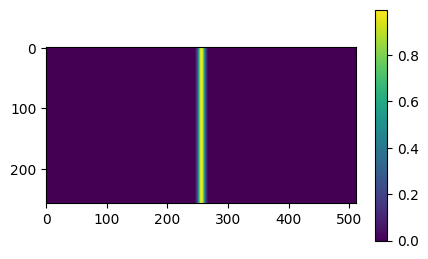

  0%|                                                                                                                                                                                                                                      | 1/2048 [00:00<04:17,  7.95it/s]

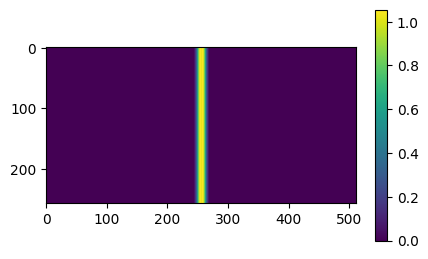

  3%|███████▏                                                                                                                                                                                                                            | 65/2048 [00:00<00:11, 167.21it/s]

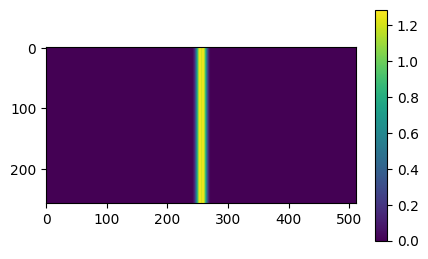

  6%|██████████████▎                                                                                                                                                                                                                    | 129/2048 [00:00<00:10, 188.57it/s]

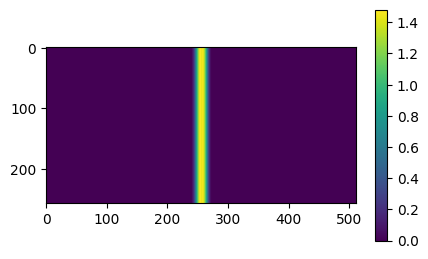

  9%|█████████████████████▍                                                                                                                                                                                                             | 193/2048 [00:01<00:10, 176.32it/s]

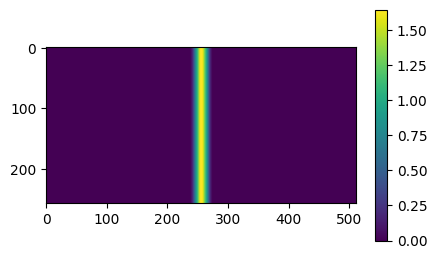

 13%|████████████████████████████▍                                                                                                                                                                                                      | 257/2048 [00:01<00:09, 186.91it/s]

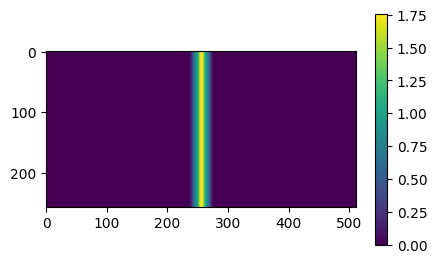

 16%|███████████████████████████████████▌                                                                                                                                                                                               | 321/2048 [00:01<00:08, 195.48it/s]

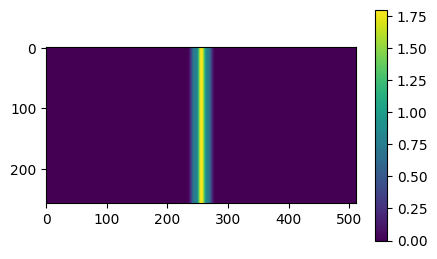

 19%|██████████████████████████████████████████▋                                                                                                                                                                                        | 385/2048 [00:02<00:08, 200.06it/s]

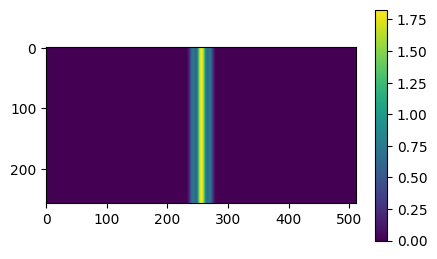

 22%|█████████████████████████████████████████████████▊                                                                                                                                                                                 | 449/2048 [00:02<00:07, 202.73it/s]

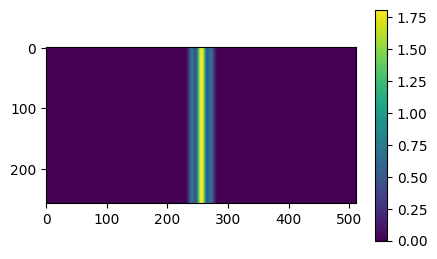

 25%|████████████████████████████████████████████████████████▊                                                                                                                                                                          | 513/2048 [00:02<00:07, 206.41it/s]

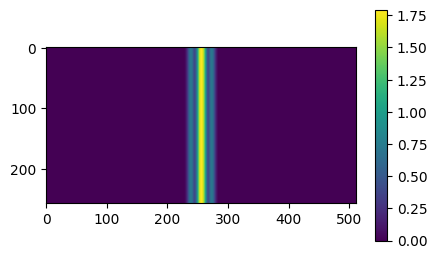

 28%|███████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 577/2048 [00:02<00:07, 208.04it/s]

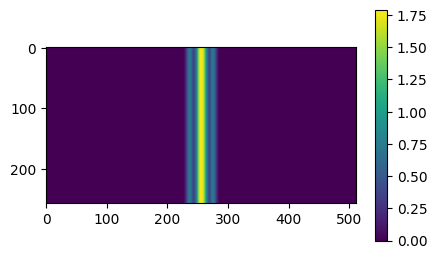

 31%|███████████████████████████████████████████████████████████████████████                                                                                                                                                            | 641/2048 [00:03<00:06, 209.37it/s]

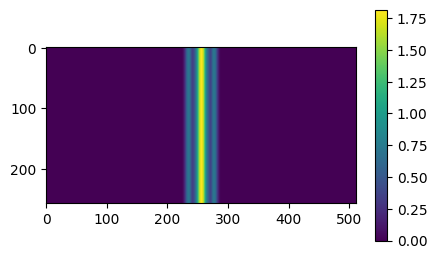

 34%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                    | 705/2048 [00:03<00:06, 210.83it/s]

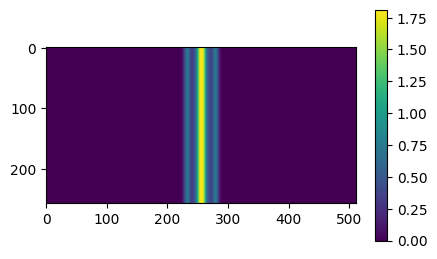

 38%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                             | 769/2048 [00:03<00:06, 209.94it/s]

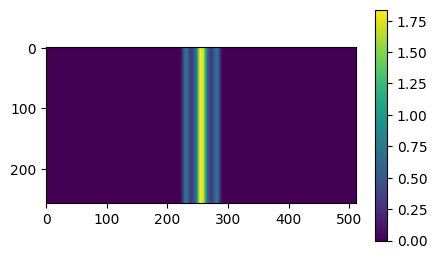

 41%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 833/2048 [00:04<00:05, 211.47it/s]

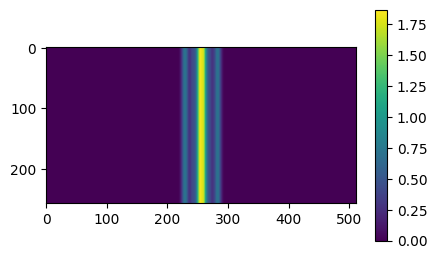

 44%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                               | 897/2048 [00:04<00:05, 212.16it/s]

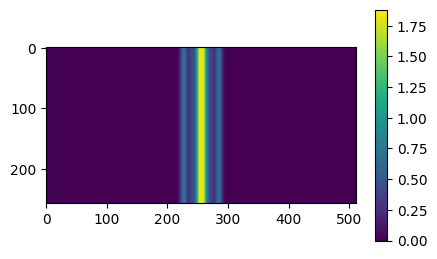

 47%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 961/2048 [00:04<00:05, 210.98it/s]

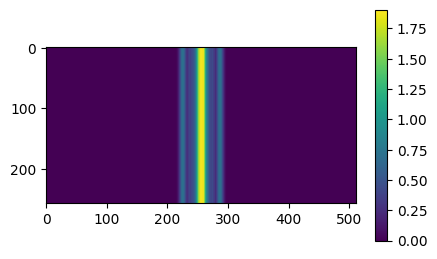

 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 1025/2048 [00:05<00:05, 193.41it/s]

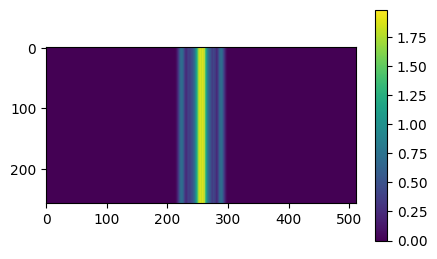

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 1089/2048 [00:05<00:04, 195.86it/s]

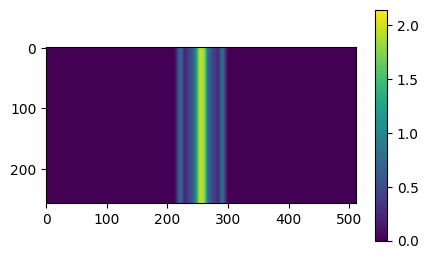

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                  | 1153/2048 [00:05<00:04, 201.83it/s]

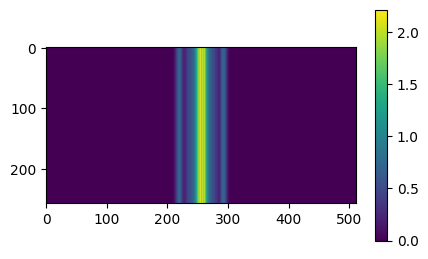

 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 1217/2048 [00:06<00:04, 205.85it/s]

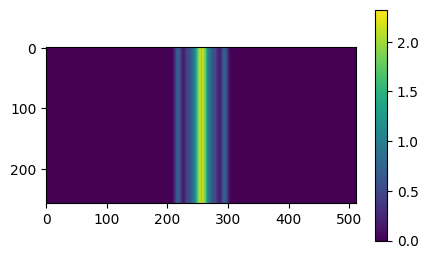

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                    | 1281/2048 [00:06<00:03, 208.49it/s]

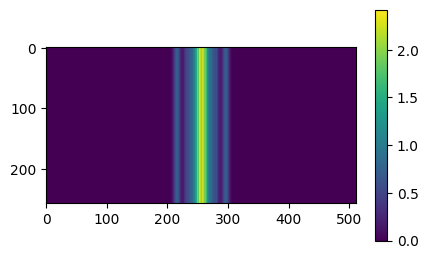

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                             | 1345/2048 [00:06<00:03, 210.03it/s]

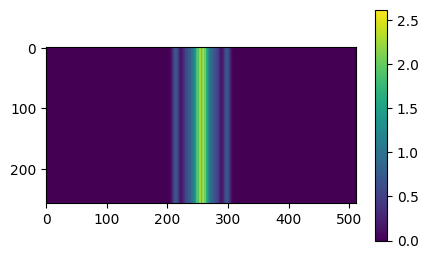

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 1409/2048 [00:06<00:03, 209.99it/s]

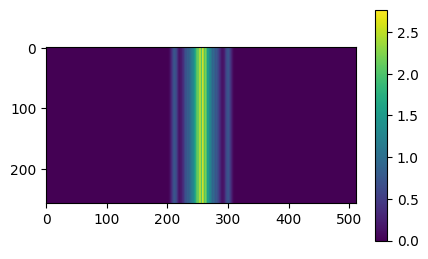

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 1473/2048 [00:07<00:02, 210.37it/s]

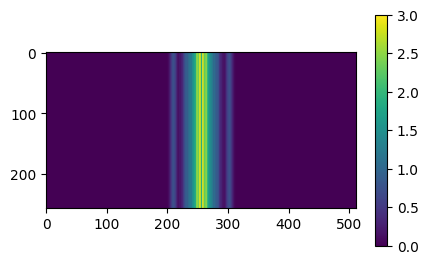

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1537/2048 [00:07<00:02, 210.20it/s]

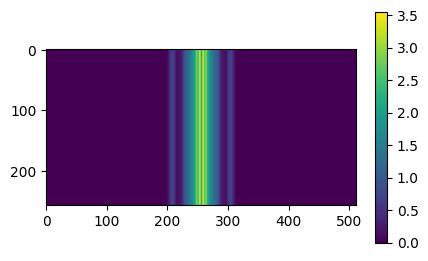

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1601/2048 [00:07<00:02, 210.96it/s]

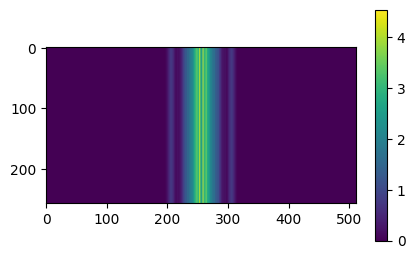

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1665/2048 [00:08<00:01, 212.99it/s]

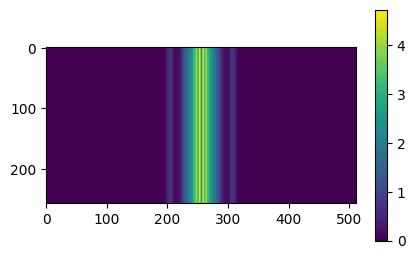

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1729/2048 [00:08<00:01, 213.25it/s]

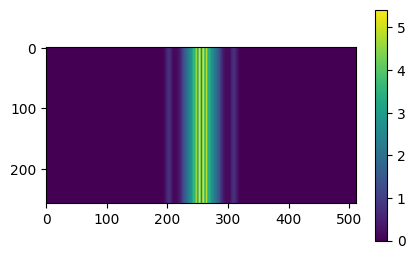

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1793/2048 [00:08<00:01, 214.29it/s]

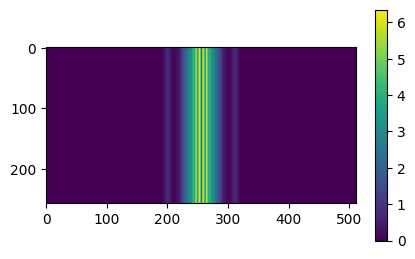

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1857/2048 [00:09<00:00, 213.55it/s]

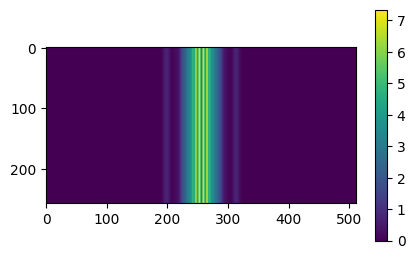

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1921/2048 [00:09<00:00, 198.49it/s]

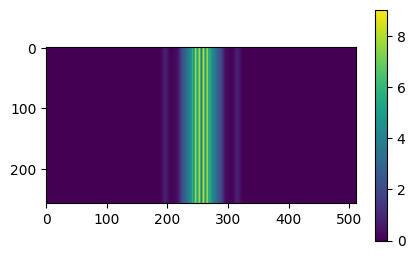

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2048/2048 [00:09<00:00, 209.71it/s]


gpu_queue_command=9942.908 ms
gpu_submit_time=9942.908 ms
gpu_pass_time=4.855 ms
gpu_cell_rate=431.963 M/s


In [11]:
total_loops = 2048
is_plot = True
plot_rate = 64

kernel_events = []
with NanoTimer() as timer:
    with cl.CommandQueue(context) as queue:
        ev_wait_for = None
        for i in tqdm(range(total_loops)):
            ev_update = gpu_program.update(
                queue, 
                global_size, workgroup_size,
                E_gpu.data, H_gpu.data,
                _E_gpu.data, _H_gpu.data,
                a_0_gpu.data, a_1_gpu.data, b_0_gpu.data,
                *[np.int32(v) for v in grid_size],
                wait_for=[ev_wait_for] if ev_wait_for != None else [],
            )
            kernel_events.append(('update', ev_update))
            ev_wait_for = ev_update
            E_gpu, _E_gpu = _E_gpu, E_gpu
            H_gpu, _H_gpu = _H_gpu, H_gpu

            if is_plot and i % plot_rate == 0:
                ev_copy = cl.enqueue_copy(queue, E_cpu_out, E_gpu.data, wait_for=[ev_wait_for])
                ev_wait_for = ev_copy
                ev_copy.wait()
                fig = plt.figure(figsize=(5,3))
                data = np.linalg.norm(E_cpu_out, ord=2, axis=3)
                #data = E_cpu_out[5,:,:,0]
                data = np.sum(data, axis=0)
                #data = np.sum(data, axis=0)
                #plt.imshow(data, cmap="jet", vmin=-1, vmax=1)
                #plt.imshow(data, cmap="jet")
                plt.imshow(data)
                plt.colorbar()
                #plt.plot(E_cpu_out[:,150,260,0].squeeze())
                plt.show()
            
            queue.flush()
        queue.finish()
gpu_submit_ns = timer.get_delta_ns()
print(f"gpu_queue_command={gpu_submit_ns*1e-6:.3f} ms")

gpu_pass_ns = gpu_submit_ns / total_loops
gpu_cell_rate = total_cells / (gpu_pass_ns*1e-9)

print(f"gpu_submit_time={gpu_submit_ns*1e-6:.3f} ms")
print(f"gpu_pass_time={gpu_pass_ns*1e-6:.3f} ms")
print(f"gpu_cell_rate={gpu_cell_rate*1e-6:.3f} M/s")